In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
# for artificial nns in pytorch the inputs should be 2D

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  2,  0,  1,  9,  3,  7, 10,  6]), tensor([8, 4]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
# torch module allows to fit a linear model with torch.nn

In [7]:
linear_model = nn.Linear(1,1) # this says we have one input feature and one target feature

In [8]:
linear_model(t_un_val)

tensor([[-4.0545],
        [-4.7703]], grad_fn=<AddmmBackward0>)

In [9]:
# we can check for the initial values of the parameters - now observe here that we do not have to explicitly specify parameters

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.9060]], requires_grad=True),
 Parameter containing:
 tensor([0.3306], requires_grad=True)]

In [11]:
# or we can do bias and weights separately

In [12]:
linear_model.bias

Parameter containing:
tensor([0.3306], requires_grad=True)

In [13]:
linear_model.weight

Parameter containing:
tensor([[-0.9060]], requires_grad=True)

In [14]:
# verify the above values are indeed correct

In [15]:
t_un_val

tensor([[4.8400],
        [5.6300]])

In [16]:
0.7568 * 3.3900 + 0.4297, 0.7568 * 5.6300 + 0.4297 # we get the values above

(2.9952520000000002, 4.6904840000000005)

In [17]:
# we need not define the loss function either now - follows is a complete training loop

In [18]:
def training_loop(n_epochs, optimizer, model, loss, tu_train, tu_val, tc_train, tc_val):

    # define the for loop here
    for epoch in range(1, n_epochs + 1):
        tp_train = model(tu_train)
        loss_train = loss(tp_train, tc_train)

        tp_val = model(tu_val)
        loss_val = loss(tp_val, tc_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}," f" Validation loss {loss_val.item():.4f}")

In [19]:
linear_model = nn.Linear(1, 1) # <1>
# notice below how the parameters are now input to the optimizer
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [20]:
training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    # we do not have to separately define the mse/loss either
    loss = nn.MSELoss(),
    tu_train = t_un_train,
    tu_val = t_un_val, 
    tc_train = t_c_train,
    tc_val = t_c_val)

Epoch 1, Training loss 266.4415, Validation loss 111.4340
Epoch 1000, Training loss 2.6924, Validation loss 9.3893
Epoch 2000, Training loss 2.1253, Validation loss 8.1867
Epoch 3000, Training loss 2.1155, Validation loss 8.0364


In [21]:
print(linear_model.weight)

Parameter containing:
tensor([[5.3610]], requires_grad=True)


In [22]:
print(linear_model.bias)

Parameter containing:
tensor([-16.7557], requires_grad=True)


In [23]:
# Okay, now to a more nn type of model - torch.nn has a sequential class just like tf

In [24]:
# let's define a nn model with sequential class

In [25]:
seq_model = nn.Sequential(
    nn.Linear(1,13), # 1 signifies the no.of inout features, and 13 the no. of hidden features
    nn.Tanh(),
    nn.Linear(13,1) # output layer, connects to the 13 hidden features, and 1 neuron for the output
)

In [26]:
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [27]:
# we can get the shapes of parameters in each layer too

In [28]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [29]:
list(seq_model.parameters())

[Parameter containing:
 tensor([[-0.8540],
         [-0.9329],
         [ 0.0391],
         [-0.6169],
         [ 0.9260],
         [-0.0043],
         [-0.1353],
         [ 0.9997],
         [ 0.3339],
         [ 0.3926],
         [-0.9732],
         [-0.1765],
         [ 0.4902]], requires_grad=True),
 Parameter containing:
 tensor([-0.9806,  0.7158,  0.2459,  0.0187,  0.1725,  0.0670, -0.8431,  0.8390,
          0.5158,  0.8868, -0.1341, -0.9117,  0.3125], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1911,  0.2072,  0.1497,  0.0467,  0.0074,  0.2549,  0.2175, -0.2485,
           0.0626, -0.0206, -0.0224, -0.0309, -0.0660]], requires_grad=True),
 Parameter containing:
 tensor([-0.1624], requires_grad=True)]

In [30]:
# can also get the names of the parameters too

In [31]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [32]:
# we can specify the names of the layers too with an ordered dictionary

In [33]:
from collections import OrderedDict

In [34]:
new_seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1,8)), 
                                           ('hidden_activation', nn.Tanh()), 
                                           ('output_linear', nn.Linear(8,1))]))

In [35]:
new_seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [36]:
for name, param in new_seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [37]:
new_seq_model.output_linear.bias

Parameter containing:
tensor([0.1695], requires_grad=True)

In [38]:
# let's train this model?

In [39]:
optimizer = optim.SGD(new_seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = new_seq_model,
    loss = nn.MSELoss(),
    tu_train = t_un_train,
    tu_val = t_un_val, 
    tc_train = t_c_train,
    tc_val = t_c_val)
    


Epoch 1, Training loss 201.0290, Validation loss 70.2727
Epoch 1000, Training loss 4.2320, Validation loss 7.5275
Epoch 2000, Training loss 3.7377, Validation loss 13.2182
Epoch 3000, Training loss 2.2812, Validation loss 7.6897
Epoch 4000, Training loss 1.8245, Validation loss 5.5883
Epoch 5000, Training loss 1.6857, Validation loss 4.6246


In [40]:
print('output', new_seq_model(t_un_val))

output tensor([[ 8.0961],
        [12.6176]], grad_fn=<AddmmBackward0>)


In [41]:
print('answer', t_c_val)

answer tensor([[ 6.],
        [11.]])


In [42]:
print('hidden', new_seq_model.hidden_linear.weight.grad)

hidden tensor([[ 4.9989e+00],
        [ 9.7471e-03],
        [-2.1486e+00],
        [-4.4601e-01],
        [ 4.0802e-03],
        [ 4.4346e-01],
        [-5.5248e+00],
        [-4.8676e+00]])


In [43]:
# let's plot the predicted values from both models

In [44]:
t_range = torch.arange(20., 90.).unsqueeze(1)

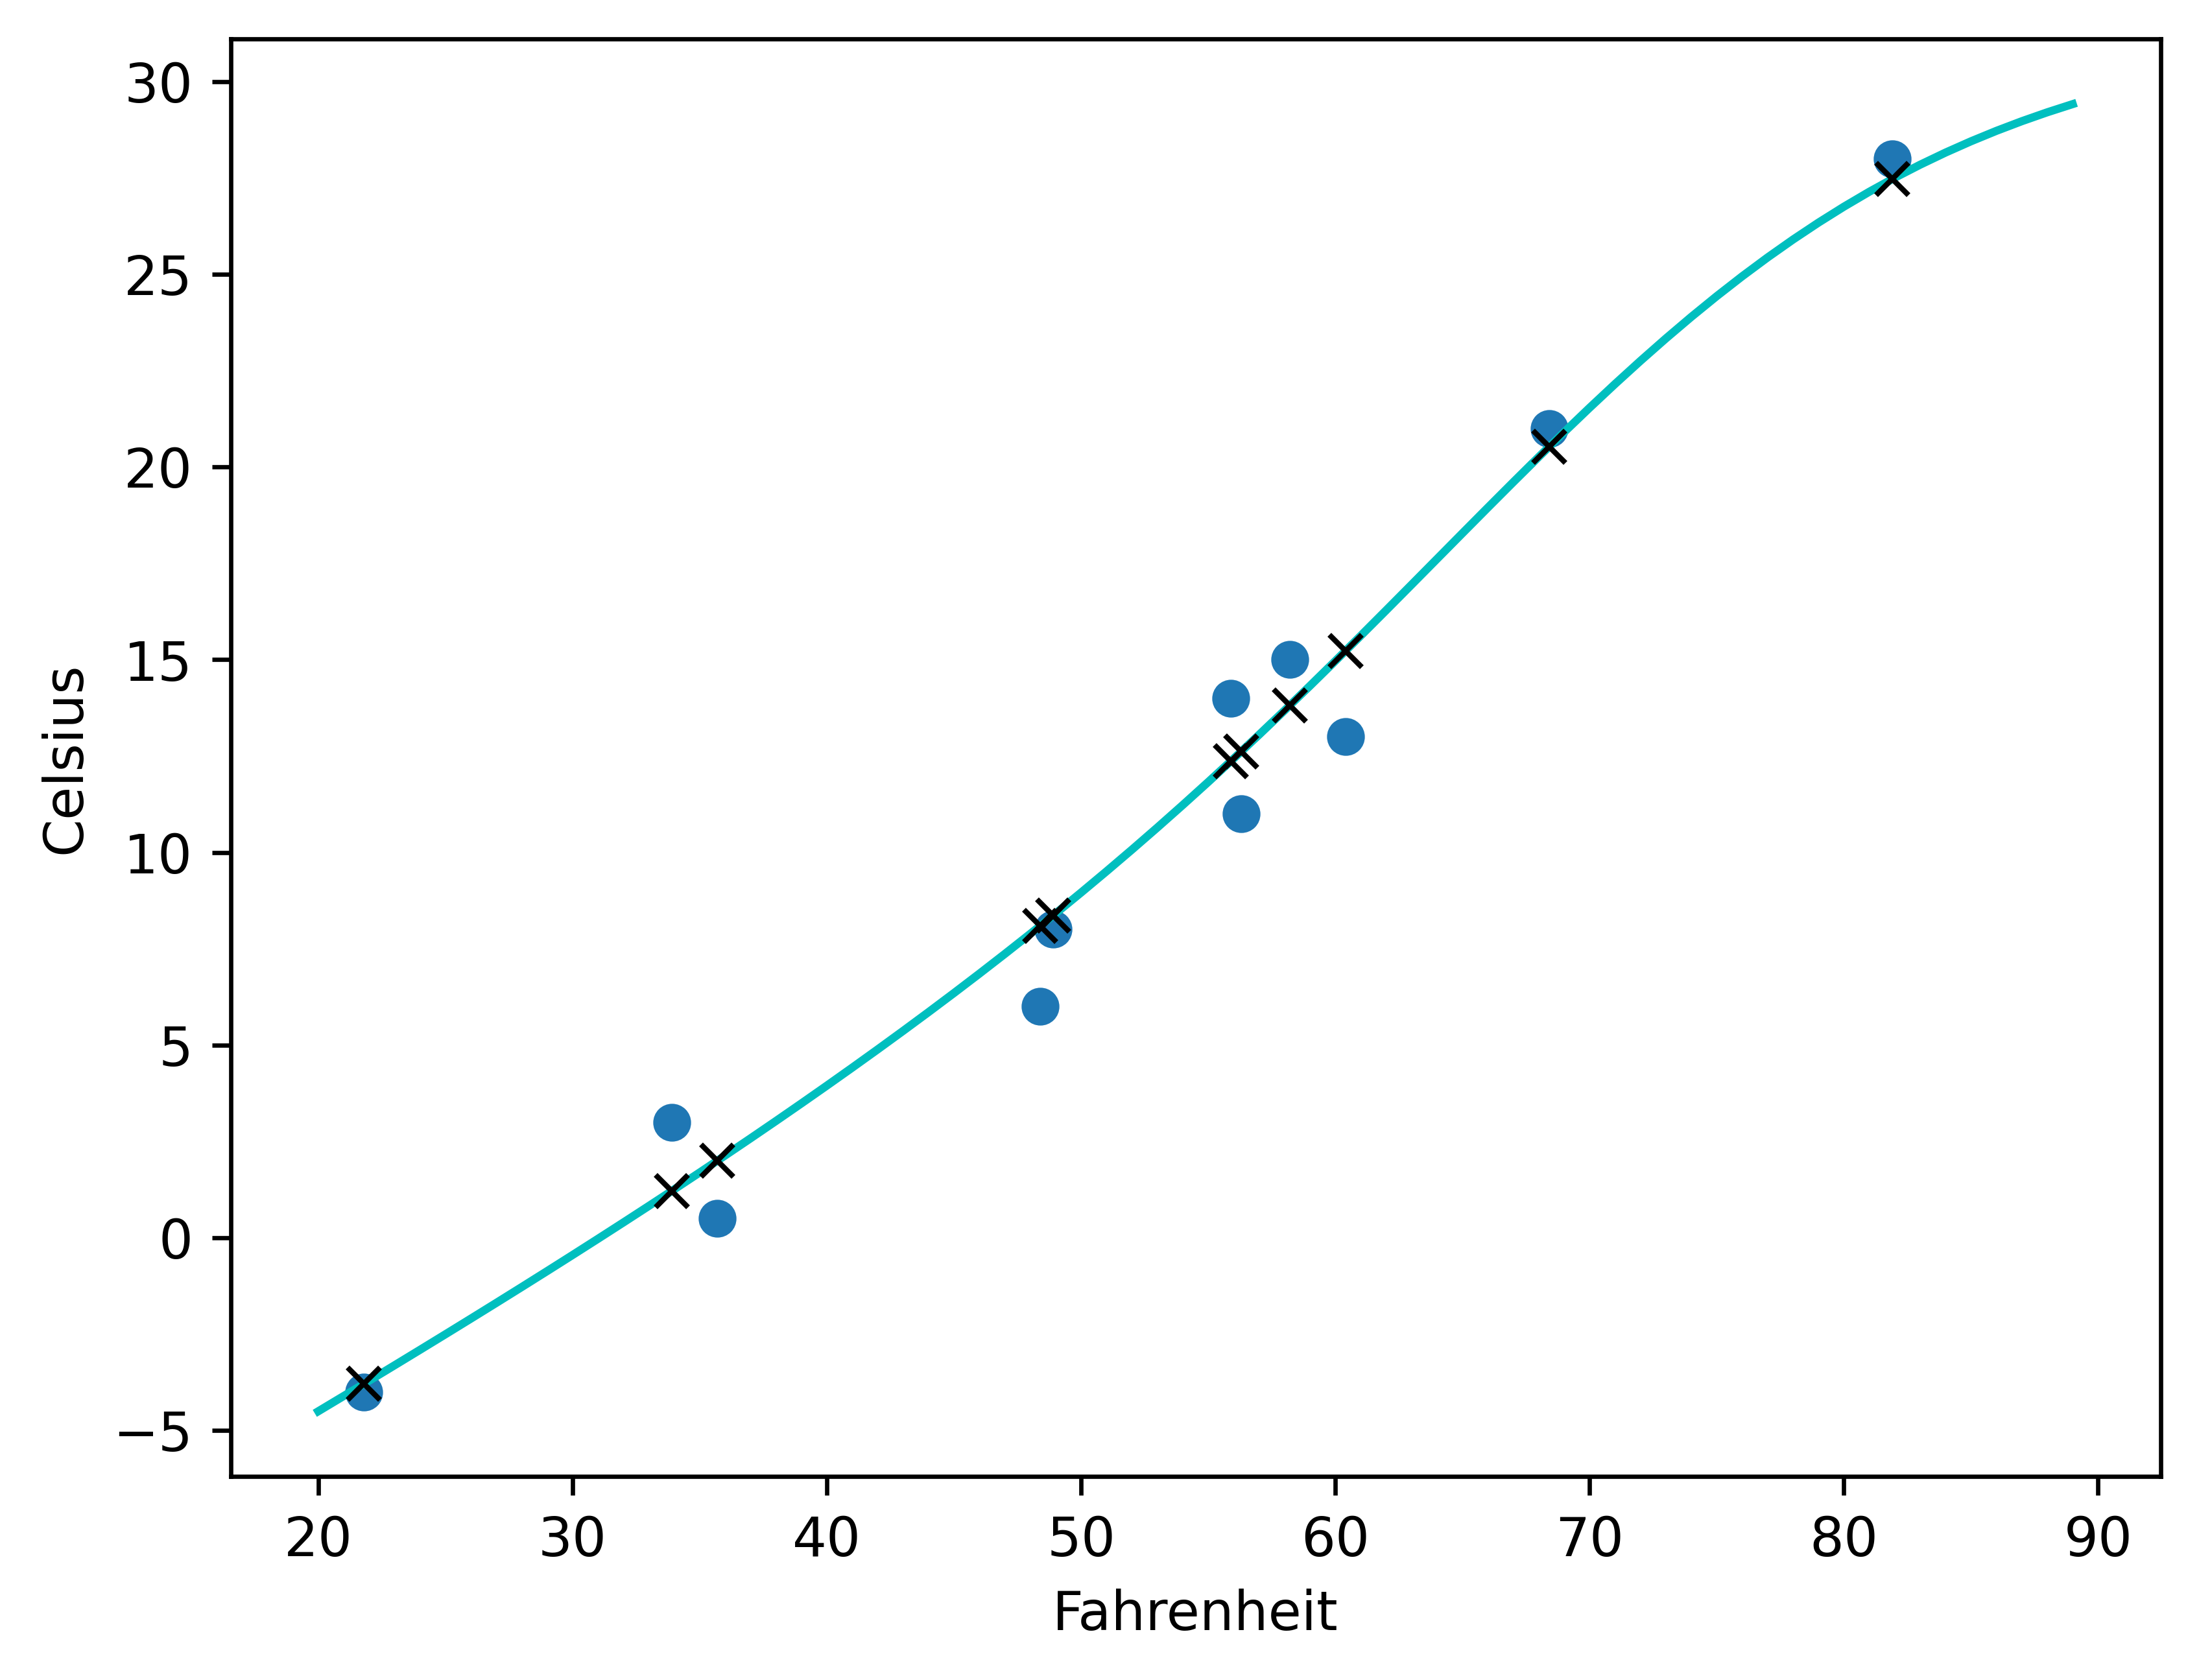

In [45]:
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), new_seq_model(0.1 * t_range).detach().numpy(), 'c-') # predictions from the nn model for the x range
plt.plot(t_u.numpy(), new_seq_model(0.1 * t_u).detach().numpy(), 'kx') # preds for existing tu inputs
plt.show()